<a href="https://colab.research.google.com/github/qahtanaa/OnSubGroupFairness/blob/main/3comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f

In [ ]:
!pip install aif360

In [ ]:
import numpy as np
import pandas as pd
from aif360.metrics import utils
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.neighbors import NearestNeighbors
from sympy import Symbol
from sympy.solvers import solve
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from aif360.algorithms.preprocessing import *
from aif360.algorithms.preprocessing.optim_preproc_helpers import distortion_functions, opt_tools
from aif360.algorithms.inprocessing import *
from aif360.algorithms.postprocessing import *
import math
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier



---



---



---

DATASET

In [ ]:
def preprocess_dataset(dataset_path, dataset_type, model):
    if dataset_type == 'German':
        df = pd.read_csv(dataset_path)
        df['age'] = df['age'].apply(lambda age: 1 if age >= 25 else 0)
        df['personal_status'] = df['personal_status'].apply(lambda sex: 1 if sex == 'male' else 0)
        print("German dataset:")
        print(df.head())
        sensitive_attributes = ['personal_status','age']
        label = 'credit'
        privileged = [1, 1]
        unprivileged = [0, 0]
        favorable_label = 1
        unfavorable_label = 2
        groups = [
                  {'name': 'Male Adult', 'attributes': {'personal_status': 1, 'age': 1}},
                  {'name': 'Female Adult', 'attributes': {'personal_status': 0, 'age': 1}},
                  {'name': 'Male Young', 'attributes': {'personal_status': 1, 'age': 0}},
                  {'name': 'Female Young', 'attributes': {'personal_status': 0, 'age': 0}}
              ]
        model = model
        #num_clust_km = 4

    elif dataset_type == 'COMPAS':
        df = pd.read_csv(dataset_path)
        selected_columns = ['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
                            'juv_other_count', 'priors_count', 'c_charge_degree',
                            'c_charge_desc', 'two_year_recid']
        df = df[selected_columns]
        df = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')].reset_index(drop=True)
        print("COMPAS dataset:")
        print(df.head())
        sensitive_attributes = ['race','sex']
        label = 'two_year_recid'
        privileged = ['Caucasian', 'Female']
        unprivileged = ['African-American', 'Male']
        favorable_label = 0
        unfavorable_label = 1
        groups = [
                  {'name': 'Caucasian Female', 'attributes': {'race': 1, 'sex': 1}},
                  {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 1}},
                  {'name': 'Causasian Male', 'attributes': {'race': 1, 'sex': 0}},
                  {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 0}}
              ]
        model = model

    elif dataset_type == 'Adult':
        df = pd.read_csv('/content/raw_adult_dataset.csv', delimiter=';')
        df['income'] = df['income'].str.strip().replace({'>50K.': '>50K', '<=50K.': '<=50K'})
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        df.replace('?', np.nan, inplace=True)
        df = df.drop(columns=['fnlwgt', 'education-num'])
        df = df[(df['race'] == 'White') | (df['race'] == 'Black')].reset_index(drop=True)
        print("Adult dataset:")
        print(df.head())
        sensitive_attributes = ['race','sex']
        label = 'income'
        privileged = ['White', 'Male']
        unprivileged = ['Black', 'Female']
        favorable_label = '>50K'
        unfavorable_label = '<=50K'
        groups = [
                  {'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}},
                  {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}},
                  {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}},
                  {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}}
              ]
        model = model

    return df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, model#, num_clust_km

In [ ]:
##################################################################################
df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, model = preprocess_dataset('/content/raw_adult_dataset.csv', 'Adult', 'Logistic Regression')
# = '/content/raw_german_dataset.csv', 'German'
# = preprocess_dataset('/content/raw_compas_dataset.csv', 'COMPAS')
# = preprocess_dataset('/content/raw_adult_dataset.csv', 'Adult')

#model == 'Logistic Regression':
#model == 'Random Forest':
#model == 'Gradient Boosting':

Adult dataset:
   age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private       11th  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship   race     sex  capital_gain  capital_loss  hours_per_week  \
0  Not-in-family  White    Male          2174             0              40   
1        Husband  White    Male             0             0              13   
2  Not-in-family  White    Male             0             0              40   
3        Husband  Black    Male             0             0              40   
4           Wife  Black  Female             0             0              40   

  native_country income  
0  United-State



---



---



---

DATA PREPARATION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

class DataPreparation():
    """
    ........
    """
    def __init__(self, df, sensitive, label, priv, unpriv, fav, unfav, categorical=[]):
        """
        Construct all necessary attributes for the data preparation.

        df : (pandas DataFrame) containing the data
        sensitive : (list(str)) specifying the column names of all sensitive features
        label : (str) specifying the label column
        priv : (list(dicts)) representation of the privileged groups
        unpriv : (list(dicts)) representation of the unprivileged groups
        fav : (str/int/..) value representing the favorable label
        unfav : (str/int/..) value representing the unfavorable label
        categorical : (list(str)) (optional) specifying column names of categorical features
        """
        self.df = df
        self.sensitive = sensitive
        self.label = label
        self.priv = priv
        self.unpriv = unpriv
        self.fav = fav
        self.unfav = unfav
        self.categorical = categorical

    def detect_missing_values(self):
        """
        Detect rows with missing values and remove them from the DataFrame.
        """
        initial_rows = len(self.df)
        self.df = self.df.dropna()
        removed_rows = initial_rows - len(self.df)

        if removed_rows > 0:
            print(f"Detected {removed_rows} rows with missing values. Removed them.")
        else:
            print("No missing values detected.")  # pass

    def binary_label(self):
        """
        Ensure the decision label and sensitive attributes are encoded as binary, where:
        - Favorable label and privileged groups are encoded as 1.
        - Unfavorable label and unprivileged groups are encoded as 0.
        """
        if len(self.priv) != 2 or len(self.unpriv) != 2:
            raise ValueError("Both 'priv' and 'unpriv' must contain exactly two values.")

        number_label_values = self.df[self.label].nunique()
        if number_label_values == 2:
            print(f"The '{self.label}' column has only two unique values.")
            self.df.loc[:, self.label] = self.df[self.label].replace([self.unfav, self.fav], [0, 1])
        else:
            print(f"The '{self.label}' column does not have exactly two unique values, as it should.")

        # Create mappings for each sensitive attribute
        race_mapping = {self.priv[0]: 1, self.unpriv[0]: 0}
        sex_mapping = {self.priv[1]: 1, self.unpriv[1]: 0}

        # Apply the mappings to the respective columns
        self.df.loc[:, self.sensitive[0]] = self.df[self.sensitive[0]].replace(race_mapping)
        self.df.loc[:, self.sensitive[1]] = self.df[self.sensitive[1]].replace(sex_mapping)

    def find_categorical_attributes(self):
        """
        Identify categorical attributes and encode.
        """
        self.attribute_types = {}

        for column in self.df.columns:
            if column == 'Group':
                continue  # Skip the 'Group' column
            elif column in self.categorical:
                self.attribute_types[column] = 'Categorical'
            elif self.df[column].nunique() == 2:
                self.attribute_types[column] = 'Categorical'
            else:
                num_float = 0
                num_text = 0
                thresh = 0.99
                num_att_in_column = len(self.df[column])

                for value in self.df[column]:
                    try:
                        float(value)
                        num_float += 1
                    except ValueError:
                        num_text += 1

                if num_float / num_att_in_column > thresh:
                    self.attribute_types[column] = 'Numerical'
                else:
                    self.attribute_types[column] = 'Categorical'
        # Boolean
        self.cat_features = []
        for attr in self.attribute_types:
            self.cat_features.append(self.attribute_types[attr] == 'Categorical')

        encoder_dict = dict()
        self.columns_categorical = self.df.columns[self.cat_features]

        for column in self.columns_categorical:
            le = LabelEncoder()
            self.df.loc[:, column] = le.fit_transform(self.df[column].values)
            mapping = dict(zip(le.classes_, range(len(le.classes_))))
            encoder_dict[column] = mapping
        print(encoder_dict, 'encoder dict')
        self.numerical_features = [not feature for feature in self.cat_features]
        self.columns_numerical = self.df.columns[self.numerical_features]

        for column in self.columns_numerical:
            self.df.loc[:, column] = self.df[column].astype(float)

        return self.attribute_types, self.cat_features, self.numerical_features

    def create_group_column(self):
        """
        Create a 'Group' column in the DataFrame based on protected attributes, privileged/unprivileged conditions, and label.
        """
        group_combinations = pd.MultiIndex.from_product([self.df[sensitive].unique() for sensitive in self.sensitive] + [self.df[self.label].unique()], names=self.sensitive + [self.label])
        print(list(enumerate(group_combinations)))
        # Create a mapping between group combinations and their corresponding numbers
        group_mapping = {group: idx for idx, group in enumerate(group_combinations)}
        reverse_group_mapping = {idx: group for group, idx in group_mapping.items()}
        self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)

        return reverse_group_mapping

    def train_test_split(self):
        X = self.df.loc[:, self.df.columns != self.label]
        y = self.df[self.label]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=self.df['Group'])  # , random_state=42

        return self.X_train, self.y_train, self.X_test, self.y_test

    def standardization_numerical(self):
        train_dataset_numerical = self.X_train[self.columns_numerical]
        test_dataset_numerical = self.X_test[self.columns_numerical]

        scaler = StandardScaler().fit(train_dataset_numerical)
        train_dataset_scaled_numerical = scaler.transform(train_dataset_numerical)
        test_dataset_scaled_numerical = scaler.transform(test_dataset_numerical)

        self.X_train.loc[:, self.columns_numerical] = train_dataset_scaled_numerical
        self.X_test.loc[:, self.columns_numerical] = test_dataset_scaled_numerical

        self.X_train = pd.concat([self.X_train, self.y_train], axis=1)
        self.X_test = pd.concat([self.X_test, self.y_test], axis=1)
        return self.X_train, self.X_test

    def prepare(self):
        """
        Perform all preprocessing steps.
        """
        self.detect_missing_values()
        self.binary_label()
        self.find_categorical_attributes()
        self.create_group_column()
        self.train_test_split()
        self.standardization_numerical()
        return self


In [ ]:
##################################################################################
#use the DataPreparation class to preprocess the dataframe
data_prep = DataPreparation(df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label)
data_prep.prepare()
data_prep.df = data_prep.df.reset_index(drop=True)
X_train, X_test = data_prep.X_train, data_prep.X_test
attribute_types = data_prep.attribute_types
cat_features = data_prep.cat_features
numerical_features = data_prep.numerical_features
reverse_group_mapping = data_prep.create_group_column()
#theoretical_num_groups = len(reverse_group_mapping)
X_train = X_train.reset_index(drop=True)
print(X_train.head())

Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Without-pay': 6}, 'education': {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}, 'marital_status': {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}, 'occupation': {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}, 'relationship': {'Husband': 0, 'Not-

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]
        age workclass education marital_status occupation relationship race  \
0 -1.326006         2         8              4          6            1    1   
1  0.712111         2        11              0          0            1    0   
2  0.787597         2         9              4          9            4    1   
3  0.561139         1        11              0          0            4    1   
4 -1.099549         2        15              4          5            1    1   

  sex  capital_gain  capital_loss  hours_per_week native_country  Group income  
0   1     -0.147173     -0.220123       -0.081643             37      0      0  
1   0     -0.147173     -0.220123       -0.331040             37      6      0  
2   0     -0.147173     -0.220123       -0.081643             37      2      0  
3   0     -0.147173     -0.220123       -0.912968             37      2 

In [ ]:
#################################################################################
num_privileged_ones = X_train[(X_train[sensitive_attributes[0]] == 1) &
                              (X_train[sensitive_attributes[1]] == 1) &
                              (X_train[label] == 1)].shape[0]

num_privileged_zeros = X_train[(X_train[sensitive_attributes[0]]) &
                               (X_train[sensitive_attributes[1]] == 1) &
                               (X_train[label] == 0)].shape[0]

# Calculating the ratio of the most privileged class
total_ratio = num_privileged_ones / num_privileged_zeros if num_privileged_zeros != 0 else float('inf')  # Avoid division by zero

print(f"Ratio of most privileged class: {total_ratio}")

Ratio of most privileged class: 0.4790803159458825


In [ ]:
#################################################################################
## Save the 'Group' column from X_train
subgroup_column_train = X_train['Group']
subgroup_column_test = X_test['Group']

# Drop the 'Group' column from X_train
X_train = X_train.drop(columns=['Group'])
X_test = X_test.drop(columns=['Group'])

In [ ]:
#distances = gower.gower_matrix(??, os_df, cat_features=cat_features)



---



---



---

METHOD 1 - CLUSTERING \\
cluster the datas (not considering the sensitive attributes), \\
 oversample each group in each cluster based on the density of the datas (oversample more where the datas are more sparse)

In [ ]:
!pip install prince

In [ ]:
!pip install gower

In [ ]:
import gower
import pandas as pd
from prince import FAMD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
exclude_attributes = [sensitive_attributes[0], sensitive_attributes[1], label]  # Add 'credit' if it is also sensitive
X_reduced = X_train.drop(columns = exclude_attributes)

In [ ]:
#!pip install gap-stat

For n_clusters = 2, The average silhouette_score is: 0.6302
WCSS: 1356981.1259
--------------------------------------------------
For n_clusters = 3, The average silhouette_score is: 0.3036
WCSS: 990729.5456
--------------------------------------------------
For n_clusters = 4, The average silhouette_score is: 0.3413
WCSS: 775906.6568
--------------------------------------------------
For n_clusters = 5, The average silhouette_score is: 0.3485
WCSS: 662530.1984
--------------------------------------------------
For n_clusters = 6, The average silhouette_score is: 0.2965
WCSS: 597314.9129
--------------------------------------------------
For n_clusters = 7, The average silhouette_score is: 0.2660
WCSS: 543252.6101
--------------------------------------------------
For n_clusters = 8, The average silhouette_score is: 0.2506
WCSS: 506041.1679
--------------------------------------------------
For n_clusters = 9, The average silhouette_score is: 0.2485
WCSS: 482087.1334
------------------

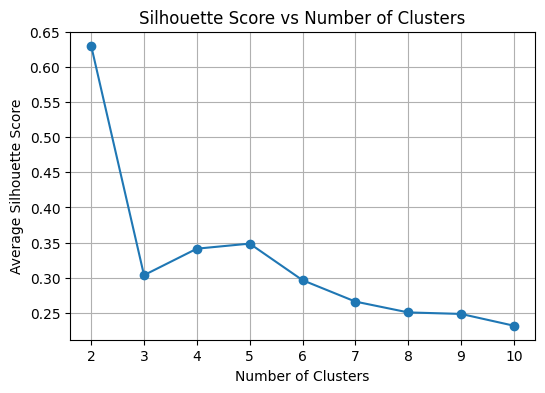

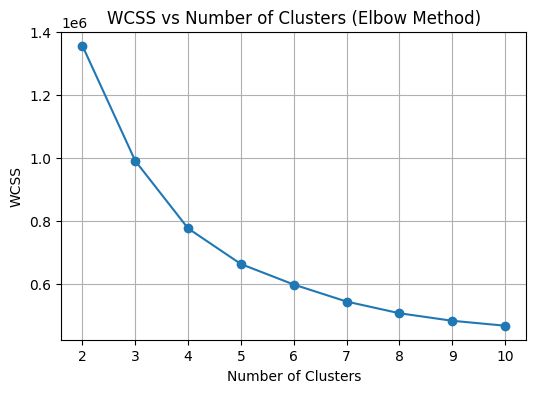

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
#from gap_statistic import OptimalK

# Load and preprocess data
# X_train_no_sens = X_train.drop(columns=['race', 'sex', 'income'])

# Encode categorical data if needed and then apply FAMD
# famd = FAMD(n_components=3, random_state=42)
# famd.fit(X_train_no_sens)
# X_reduced = famd.transform(X_train_no_sens)
#X_reduced = X_train_no_sens  # Assuming X_train_no_sens is already defined and preprocessed

# Setting the range for possible n_clusters
range_n_clusters = range(2, 11)  # For example, testing from 2 to 10 clusters

# Initialize lists to store metrics
silhouette_avg_scores = []
wcss = []

# Compute Silhouette Score and WCSS for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Silhouette Score
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

    # WCSS (Within-Cluster Sum of Squares)
    wcss.append(kmeans.inertia_)

    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg:.4f}")
    print(f"WCSS: {kmeans.inertia_:.4f}")
    print("-" * 50)

# Plotting the silhouette scores to find the best n_clusters
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

# Plotting the WCSS to find the elbow
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, wcss, marker='o', label='WCSS (Elbow Method)')
plt.title('WCSS vs Number of Clusters (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# # Gap Statistic
# optimalK = OptimalK(parallel_backend='joblib')
# n_clusters = optimalK(X_reduced, cluster_array=range_n_clusters)
# print(f'Optimal number of clusters based on Gap Statistic: {n_clusters}')

# # Plotting the gap statistic
# plt.figure(figsize=(6,4))
# plt.plot(range_n_clusters, optimalK.gap_df.gap_value, marker='o')
# plt.title('Gap Statistic')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Gap Value')
# plt.grid(True)
# plt.show()


In [ ]:
##################################################################################

# Clustering with K-Means
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Add cluster labels to the original DataFrame
X_train['Cluster_Labels'] = clusters

# Evaluate and display the clustering quality
silhouette_avg = silhouette_score(X_reduced, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Now the original X_train DataFrame includes the 'Cluster_Labels'
#print(X_train.head())

# Analyzing each cluster for sensitive attributes
cluster_analysis = X_train.groupby(['Cluster_Labels', sensitive_attributes[0], sensitive_attributes[1], label]).size().reset_index(name='Count')
# Pivot table for better visualization per cluster
pivot_table = cluster_analysis.pivot_table(index=[sensitive_attributes[0], sensitive_attributes[1], label], columns='Cluster_Labels', values='Count', fill_value=0)
# Display the pivot table
print(pivot_table)


Silhouette Score: 0.3485354366465851
Cluster_Labels      0    1     2     3    4
race sex income                            
0    0   0        475   37   615   199   45
         1         37    1    45     4    1
     1   0        399   38   528   222   28
         1        135    8   125    13    5
1    0   0       2764  230  3371   742  192
         1        439   33   522    11   14
     1   0       5151  326  5097  1625  588
         1       2726  147  2988   169   96


In [ ]:
def calculate_samples_to_add(X_train, sensitive_attributes, label, total_ratio):
    """
    Calculate the number of synthetic positive samples to add for each group to achieve the specified total_ratio.

    Parameters:
    X_train (DataFrame): The training dataset.
    sensitive_attributes (list): List of columns defining the groups.
    label (str): The column name for the target binary class.
    total_ratio (float): The target imbalance ratio (number of positives / number of negatives).

    Returns:
    DataFrame: A DataFrame containing each group, the current imbalance ratio, and the number of samples to add.
    """
    results = []
    groups = X_train.groupby(sensitive_attributes)

    for group_values, group_df in groups:
        positive_count = group_df[group_df[label] == 1].shape[0]
        negative_count = group_df[group_df[label] == 0].shape[0]

        if negative_count == 0:
            current_ratio = float('inf')
        else:
            current_ratio = positive_count / negative_count

        # Calculate the number of samples to add to match the total_ratio
        if current_ratio < total_ratio:
            required_positives = int((total_ratio * negative_count) - positive_count)
            samples_to_add = max(0, required_positives)  # Ensure no negative numbers
        else:
            samples_to_add = 0

        results.append({
            "group": group_values,
            "current_ratio": current_ratio,
            "samples_to_add": samples_to_add
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by="samples_to_add", ascending=False)
    print('Samples to add:\n',result_df)

    return result_df

In [ ]:
def calculate_mean_distance_within_cluster(cluster_samples, cat_features):
    if len(cluster_samples) < 2:
        return 0
    # Calculate pairwise Gower distances
    pairwise_dist = gower.gower_matrix(cluster_samples, cat_features=cat_features)
    upper_tri_indices = np.triu_indices_from(pairwise_dist, k=1)
    avg_distance = np.mean(pairwise_dist[upper_tri_indices])
    return avg_distance

In [ ]:
def distribute_samples_based_on_density(X_train, cluster_label, sensitive_attributes, label, total_ratio, cat_features, min_samples=5):
    adjustments = calculate_samples_to_add(X_train, sensitive_attributes, label, total_ratio)

    distribution = []

    for _, row in adjustments.iterrows():
        group = row['group']
        total_samples_to_add = row['samples_to_add']
        group_df = X_train[(X_train[list(sensitive_attributes)] == group).all(axis=1) & (X_train[label] == 1)]

        cluster_distances = {}
        for cluster in group_df[cluster_label].unique():
            cluster_samples = group_df[group_df[cluster_label] == cluster].drop(columns=[cluster_label])
            if len(cluster_samples) >= min_samples:
                mean_distance = calculate_mean_distance_within_cluster(cluster_samples, cat_features)
                cluster_distances[cluster] = mean_distance
                #print(mean_distance, cluster, 'vediamo se ha senso)')

        if not cluster_distances:
            continue

        total_distance = sum(cluster_distances.values())
        if total_distance == 0:
            continue

        for cluster, mean_distance in cluster_distances.items():
            proportion = mean_distance / total_distance
            synthetic_samples = int(total_samples_to_add * proportion)
            distribution.append({
                "group": group,
                "cluster": cluster,
                "samples_to_add": synthetic_samples
            })

    distribution_df = pd.DataFrame(distribution)
    print(distribution_df)
    return distribution_df

In [ ]:
def generate_synthetic_samples(group_df, num_samples, cat_features):
    """
    Generate synthetic samples within the group using an interpolation method.

    Parameters:
    group_df (DataFrame): Data of the group to oversample.
    num_samples (int): Number of synthetic samples to generate.
    cat_features (list): Boolean list, True for categorical features.

    Returns:
    DataFrame: A DataFrame of synthetic samples.
    """
    os_df = group_df
    synthetic_samples = []
    while len(synthetic_samples) < num_samples:
        # Randomly pick a sample
        idx_A = random.choice(group_df.index)
        point_A = group_df.loc[idx_A]

        # Find nearest neighbors (excluding itself)
        distances = gower.gower_matrix(os_df.loc[[idx_A]], os_df, cat_features=cat_features)
        neighbors = np.argsort(distances.flatten())[1:6]

        # Choose one of the nearest neighbors
        idx_B = random.choice(neighbors)
        point_B = os_df.iloc[idx_B]

        # Generate a synthetic point
        synthetic_point = {}
        for i, col in enumerate(group_df.columns):
            if cat_features[i]:
                neighbor_values = os_df.iloc[neighbors][col].tolist()
                synthetic_point[col] = max(set(neighbor_values), key=neighbor_values.count)
            else:
                alpha = np.random.rand()
                synthetic_point[col] = point_A[col] + alpha * (point_B[col] - point_A[col])

        synthetic_samples.append(synthetic_point)

    return pd.DataFrame(synthetic_samples)


In [ ]:
def oversample_clusters(X_train, cluster_label, sensitive_attributes, label, total_ratio, cat_features):
    """
    Apply oversampling to each cluster as specified in the distribution DataFrame and collect all synthetic samples.

    Parameters:
    X_train (DataFrame): Original training dataset.
    cat_features (list): List of indices for categorical features.

    Returns:
    DataFrame: A DataFrame containing all the synthetic samples.
    """

    distribution_inverse = distribute_samples_based_on_density(X_train, cluster_label, sensitive_attributes, label, total_ratio, cat_features)
    synthetic_dfs = []  # Initialize an empty list to collect synthetic dataframes

    for index, row in distribution_inverse.iterrows():
        group = row['group']
        cluster = row['cluster']
        samples_to_add = row['samples_to_add']

        # Filter for the specific group and cluster
        group_df = X_train[(X_train[list(sensitive_attributes)] == group).all(axis=1) &      #[list(group_columns)] == group).all(axis=1) &
                           (X_train[label] == 1) &
                           (X_train[cluster_label] == cluster)]

        # Generate synthetic samples
        if not group_df.empty and samples_to_add > 0:
            synthetic_df = generate_synthetic_samples(group_df.drop(columns= [cluster_label]), samples_to_add, cat_features)
            synthetic_dfs.append(synthetic_df)

    # Concatenate all synthetic dataframes into one
    if synthetic_dfs:
        all_synthetic_samples = pd.concat(synthetic_dfs, ignore_index=True)
    else:
        all_synthetic_samples = pd.DataFrame()

    return all_synthetic_samples


In [ ]:
###################################################################################
all_synthetic_samples_km = oversample_clusters(X_train, 'Cluster_Labels', sensitive_attributes, label, total_ratio, cat_features)
#print('Synthetic samples:\n',all_synthetic_samples_km)

Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
     group  cluster  samples_to_add
0   (1, 0)        2             412
1   (1, 0)        0             402
2   (1, 0)        1             550
3   (1, 0)        3             526
4   (1, 0)        4             585
5   (0, 0)        0             283
6   (0, 0)        2             284
7   (0, 1)        2              55
8   (0, 1)        0              54
9   (0, 1)        3              61
10  (0, 1)        4              55
11  (0, 1)        1              69
12  (1, 1)        2               0
13  (1, 1)        0               0
14  (1, 1)        1               0
15  (1, 1)        3               0
16  (1, 1)        4               0


In [ ]:
############################################################
X_train = X_train.drop(columns=['Cluster_Labels'])
X_train_resampled_km = pd.concat([X_train, all_synthetic_samples_km], ignore_index=True)



---



---



---

METHOD 2 - TAXONOMY \\
compute the 5 nearest neighbors for each point, \\
count how many NN are from the same group \\
define the Safe, Borderline, Noise, Outliers datas \\
oversample using Borderline/Safe/Noise


In [ ]:
import numpy as np
import pandas as pd
import gower
import random

def custom_smote_tax(X_train, cat_features, pu_ix, nu_ix, group_column_train, s=0.01, b=0.98, r=0.01, o=0, total_ratio=1):

    X2_df = X_train[group_column_train == pu_ix]
    X3_df = X_train[group_column_train == nu_ix]
    X2 = X2_df.values
    X3 = X3_df.values

    PU = len(X2)
    NU = len(X3)

    if (PU / NU) > total_ratio:
        oversampling_target = (PU / total_ratio) - NU
        os_df = X3_df
        os_ix = nu_ix
    else:
        oversampling_target = (total_ratio * NU) - PU
        os_df = X2_df
        os_ix = pu_ix

    weights = calculate_weights_taxonomy(os_df, cat_features, X_train, group_column_train, s, b, r, o)
    weights /= np.sum(weights)

    synthetic_samples = []

    while len(synthetic_samples) < oversampling_target:
        idx_A = np.random.choice(os_df.index, p=weights)
        point_A = os_df.loc[idx_A]

        distances = gower.gower_matrix(os_df.loc[[idx_A]], os_df, cat_features=cat_features)
        neighbors = np.argsort(distances.flatten())[1:6]

        idx_B = random.choice(neighbors)
        point_B = os_df.iloc[idx_B]

        synthetic_point = {}
        for i, col in enumerate(os_df.columns):
            if cat_features[i]:
                neighbor_values = os_df.iloc[neighbors][col].tolist()
                synthetic_point[col] = max(set(neighbor_values), key=neighbor_values.count)
            else:
                alpha = np.random.rand()
                synthetic_point[col] = point_A[col] + alpha * (point_B[col] - point_A[col])

        synthetic_samples.append(synthetic_point)

    return pd.DataFrame(synthetic_samples), len(synthetic_samples), os_ix

def calculate_weights_taxonomy(X2_df, cat_features, X_train, group_column_train, s=0.01, b=0.98, r=0.01, o=0):
    weights = np.zeros(len(X2_df))

    for ix in range(len(X2_df)):
        idx_complete_df = X2_df.index[ix]

        # Compute Gower distances between the current sample and all samples in X_train
        distances = gower.gower_matrix(X_train.loc[[idx_complete_df]], X_train, cat_features=cat_features)
        neighbors = np.argsort(distances.flatten())[1:6]  # Find 5 nearest neighbors excluding itself

        # Identify the neighbors that belong to the same subgroup
        same_subgroup_indices = [X_train.index[idx] for idx in neighbors if group_column_train[X_train.index[idx]] == group_column_train[X_train.index[idx_complete_df]]]
        # Print the indices of the nearest neighbors
        print(f"Sample index: {idx_complete_df}, Nearest neighbors indices: {[X_train.index[idx] for idx in neighbors]}, Same subgroup indices: {[same_subgroup_indices]}")

        if len(same_subgroup_indices) in [4, 5]:
            weights[ix] = s
        elif len(same_subgroup_indices) in [2, 3]:
            weights[ix] = b
        elif len(same_subgroup_indices) == 1:
            solo_neighbor = same_subgroup_indices[0]

            # Compute Gower distances for the solo neighbor considering the entire dataset
            distances_solo = gower.gower_matrix(X_train.loc[[solo_neighbor]], X_train, cat_features=cat_features)
            neighbors_solo = np.argsort(distances_solo.flatten())[1:6]
            same_class_neighbors = sum(1 for neighbor_index in neighbors_solo if group_column_train[X_train.index[neighbor_index]] == group_column_train[X_train.index[idx_complete_df]])

            if same_class_neighbors in [0, 1]:
                weights[ix] = r
            else:
                weights[ix] = b
        elif len(same_subgroup_indices) == 0:
            weights[ix] = o
        else:
            weights[ix] = b

    return weights


In [ ]:
def oversample_groups(X_train, cat_features, custom_smote, group_column_train, total_ratio, reverse_group_mapping):
    """
    Function to oversample multiple groups automatically based on group labels.

    Parameters:
    - X_train: Preprocessed training dataset.
    - cat_features: List indicating categorical features.
    - custom_smote: Custom SMOTE function to be used.
    - group_column_train: Column containing the group label for each instance.
    - total_ratio: Desired ratio of positive to negative labels.
    - reverse_group_mapping: Mapping of groups to sensitive attributes and labels.

    Returns:
    - synthetic_samples_matrix: Matrix containing all generated synthetic samples.
    - synthetic_samples_group: Array of group labels for the synthetic samples.
    """

    synthetic_samples = []
    synthetic_samples_group = []

    groups = sorted(group_column_train.unique())
    paired_groups = [(groups[i], groups[i+1]) for i in range(0, len(groups), 2)]

    for group1, group2 in paired_groups:
        ########## Determine pu_ix and nu_ix using reverse_group_mapping ##########
        if reverse_group_mapping[group1][2] == 1:
            pu_ix = group1
            nu_ix = group2
        else:
            pu_ix = group2
            nu_ix = group1
        ##########################################################################

        group_df_pu = X_train[group_column_train == pu_ix]
        group_df_nu = X_train[group_column_train == nu_ix]
        positive_count = group_df_pu[group_df_pu[label] == 1].shape[0]
        negative_count = group_df_nu[group_df_nu[label] == 0].shape[0]

        if positive_count == 0 or negative_count == 0:
            continue

        current_ratio = positive_count / negative_count

        if current_ratio == total_ratio:
            continue  # Skip the most privileged group

        synthetic_points, synthetic_count, os_ix = custom_smote(X_train, cat_features, pu_ix, nu_ix, group_column_train, total_ratio=total_ratio)
        pu_column = np.full((len(synthetic_points), 1), os_ix)
        synthetic_samples.append(synthetic_points)
        synthetic_samples_group.append(pu_column)
        print(f"Oversampling for group pair ({pu_ix}, {nu_ix}): Added {synthetic_count} synthetic samples in {os_ix}.")

    synthetic_samples_matrix = pd.concat(synthetic_samples, ignore_index=True)
    synthetic_samples_group = np.concatenate(synthetic_samples_group)

    return synthetic_samples_matrix, synthetic_samples_group


In [ ]:
##################################################################################
synthetic_samples_matrix_tax, synthetic_samples_group_tax = oversample_groups(X_train, cat_features, custom_smote_tax, subgroup_column_train, total_ratio, reverse_group_mapping)
X_train_resampled_tax = pd.concat([X_train, pd.DataFrame(synthetic_samples_matrix_tax, columns=X_train.columns)], ignore_index=True)
subgroup_column_resampled_tax = pd.concat([subgroup_column_train, pd.Series(synthetic_samples_group_tax.flatten())], ignore_index=True)


Sample index: 11, Nearest neighbors indices: [12155, 5674, 28859, 21464, 6464], Same subgroup indices: [[12155, 5674, 28859, 21464, 6464]]
Sample index: 42, Nearest neighbors indices: [6031, 19849, 20858, 19558, 15003], Same subgroup indices: [[6031, 19849, 20858, 19558, 15003]]
Sample index: 75, Nearest neighbors indices: [22841, 14978, 25217, 17521, 10163], Same subgroup indices: [[22841, 14978, 25217, 17521, 10163]]
Sample index: 86, Nearest neighbors indices: [3639, 9922, 28686, 4452, 1228], Same subgroup indices: [[3639, 9922, 28686, 4452, 1228]]
Sample index: 103, Nearest neighbors indices: [18377, 14654, 14202, 17734, 19464], Same subgroup indices: [[18377, 14654, 14202, 17734, 19464]]
Sample index: 154, Nearest neighbors indices: [11712, 7773, 7133, 27495, 14520], Same subgroup indices: [[11712, 7773, 7133, 27495, 14520]]
Sample index: 156, Nearest neighbors indices: [13562, 17564, 19774, 14011, 10466], Same subgroup indices: [[13562, 17564, 19774, 14011, 10466]]
Sample index: 



---

---



---

METHOD 3 - DBSCAN \\
for each group in the dataset: \\
-cluster the group in order to find the points that are considered Core, Borderline, Noise by the DBSCAN algorithm \\
-oversample each group using the Borderline points, to reach the imbalance ratio of the most priviledged group



In [ ]:
# find the eps
from gower import gower_matrix
from sklearn.cluster import DBSCAN
import math

# Filter the dataset for one specific combination of sensitive attributes and labels
filtered_data = X_train[(X_train[sensitive_attributes[0]] == 1) & (X_train[sensitive_attributes[1]] == 0) & (X_train[label] == 1)]

# Calculate Gower distance matrix
distance_matrix = gower_matrix(filtered_data, cat_features=cat_features)

eps = 0.15
# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=round(math.log(len(filtered_data))), metric='precomputed')  # Set appropriate values for eps and min_samples
clusters = dbscan.fit_predict(distance_matrix)

# Assign cluster labels to dataframe
filtered_data['cluster'] = clusters

print(round(math.log(len(filtered_data))))
# Display the number of samples in each cluster
cluster_counts = filtered_data.groupby(['cluster']).size()
print("Number of samples in each cluster:")
print(cluster_counts)

# Get cluster labels
labels = dbscan.labels_

# Get core samples
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Identify core, border, and noise points
core_points = filtered_data[core_samples_mask]
border_points = filtered_data[~core_samples_mask & (labels != -1)]
noise_points = filtered_data[labels == -1]

# For example, you can print the number of points in each category
print("Number of core points:", len(core_points))
print("Number of border points:", len(border_points))
print("Number of noise points:", len(noise_points))


7
Number of samples in each cluster:
cluster
-1     63
 0    637
 1    319
dtype: int64
Number of core points: 884
Number of border points: 72
Number of noise points: 63


<ipython-input-74-2e0b5aa7c251>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster'] = clusters


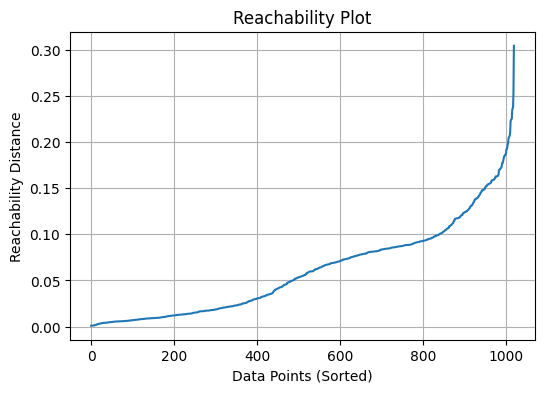

In [ ]:
from gower import gower_matrix
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Compute distances to nearest neighbors
k = round(math.log(len(filtered_data)))
nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
distances, _ = nbrs.kneighbors(distance_matrix)

# Compute reachability distances
reachability_distances = np.mean(distances[:, 1:], axis=1)

# Sort reachability distances in ascending order
sorted_distances = np.sort(reachability_distances)

# Plot reachability distances
plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('Reachability Plot')
plt.xlabel('Data Points (Sorted)')
plt.ylabel('Reachability Distance')
plt.grid(True)
plt.show()


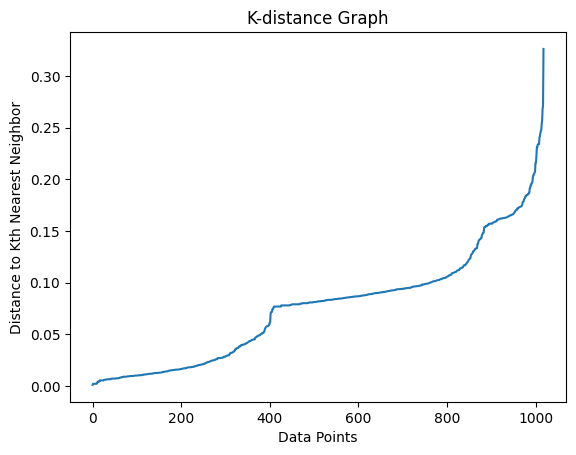

In [ ]:
# Compute distances to K-nearest neighbors
k = round(math.log(len(filtered_data))) # Choose the value of K
nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
distances, _ = nbrs.kneighbors(distance_matrix)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot K-distance graph
plt.plot(range(len(filtered_data)), sorted_distances)
plt.xlabel('Data Points')
plt.ylabel('Distance to Kth Nearest Neighbor')
plt.title('K-distance Graph')
plt.show()


In [ ]:
#GRID SEARCH
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from gower import gower_matrix
import itertools

def evaluate_clustering(X, labels):
    # Compute silhouette score
    if len(set(labels)) > 1:
        return silhouette_score(X, labels, metric='precomputed')
    else:
        return -1  # Single cluster, not useful

def grid_search_dbscan(X, cat_features, eps_range, min_samples_range):
    best_score = -1
    best_params = None

    distance_matrix = gower_matrix(X, cat_features=cat_features)

    for eps, min_samples in itertools.product(eps_range, min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = dbscan.fit_predict(distance_matrix)

        score = evaluate_clustering(distance_matrix, labels)
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

    return best_params, best_score

# Define the range of eps and min_samples values
eps_range = np.linspace(0.1, 0.5, 10)
min_samples_range = range(3, 10)


In [ ]:
def find_best_params_for_groups(X_train, cat_features, group_column):
    unique_groups = group_column.unique()
    best_params_per_group = {}

    for group in unique_groups:
        X_group = X_train[group_column == group]
        best_params, best_score = grid_search_dbscan(X_group, cat_features, eps_range, min_samples_range)
        best_params_per_group[group] = best_params
        print(f"Group {group}: Best Params = {best_params}, Best Score = {best_score}")

    return best_params_per_group

# Example usage
best_params_per_group = find_best_params_for_groups(X_train, cat_features, subgroup_column_train)


Group 0: Best Params = {'eps': 0.18888888888888888, 'min_samples': 3}, Best Score = 0.3467554450035095
Group 6: Best Params = {'eps': 0.18888888888888888, 'min_samples': 3}, Best Score = 0.2649632692337036
Group 2: Best Params = {'eps': 0.23333333333333334, 'min_samples': 3}, Best Score = 0.3415577709674835
Group 1: Best Params = {'eps': 0.23333333333333334, 'min_samples': 3}, Best Score = 0.5033307075500488
Group 3: Best Params = {'eps': 0.23333333333333334, 'min_samples': 3}, Best Score = 0.3929685354232788
Group 4: Best Params = {'eps': 0.23333333333333334, 'min_samples': 3}, Best Score = 0.3179481327533722
Group 5: Best Params = {'eps': 0.23333333333333334, 'min_samples': 3}, Best Score = 0.39654356241226196
Group 7: Best Params = {'eps': 0.18888888888888888, 'min_samples': 7}, Best Score = 0.2169475108385086


In [ ]:
def custom_smote_dbscan(X_train, cat_features, pu_ix, nu_ix, group_column_train, total_ratio):
    """
    X_train is the training dataset preprocessed, subgroup_column_train is a column containing the subgroup of each
    instance in X_train
    """
    cat_attr_ix = [i for i, value in enumerate(cat_features) if value]

    X2_df = X_train[group_column_train == pu_ix]
    X2 = X2_df.values
    X3_df = X_train[group_column_train == nu_ix]
    X3 = X3_df.values

    PU = len(X2)
    NU = len(X3)

    # Determine the oversampling target based on a given total_ratio
    if (PU / NU) > total_ratio:
        oversampling_target = (PU / total_ratio) - NU
        os_df = X3_df
        os_ix = nu_ix
    elif (PU / NU) == total_ratio:
        print("The ratio of PU to NU is within the acceptable range of total_ratio.")
        return [], 0, pu_ix
    else:
        oversampling_target = (total_ratio * NU) - PU
        os_df = X2_df
        os_ix = pu_ix
    os_df = os_df.reset_index(drop=True)

    # Calculate Gower distance matrix
    distance_matrix = gower_matrix(os_df, cat_features=cat_features)

    # group 0 : eps = 0.23
    # group 1 : eps = 0.275
    # group 2 : eps = 0.26
    # group 3 : eps = 0.26
    # group 4 : eps = 0.26
    # group 5 : eps = 0.28
    # group 6 : eps = 0.28
    # group 7 : eps = 0.265
    # DBSCAN parameters per group
    eps = {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1}
    #eps = {0: 0.225, 1: 0.26, 2: 0.22, 3: 0.255, 4: 0.255, 5: 0.275, 6: 0.27, 7: 0.25}
    k = round(math.log(len(os_df)))
    dbscan = DBSCAN(eps=eps[os_ix], min_samples=k, metric='precomputed')
    clusters = dbscan.fit_predict(distance_matrix)

    # Get cluster labels
    labels = dbscan.labels_

    # Get core samples
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    # Identify core, border, and noise points
    core_points = os_df[core_samples_mask]
    border_points = os_df[~core_samples_mask & (labels != -1)]
    noise_points = os_df[labels == -1]

    if len(border_points) == 0:
        border_points = core_points

    # Initialize synthetic samples list
    synthetic_samples = []

    border_indices = border_points.index.tolist()
    random.shuffle(border_indices)
    current_index = 0

    while len(synthetic_samples) < oversampling_target:
        idx_A = border_indices[current_index % len(border_indices)]
        #idx_A = core_indices[current_index % len(core_indices)]
        #print(idx_A, 'indice A')
        current_index += 1
        point_A = os_df.loc[idx_A]

        # Ensure point B is not a noise point
        distances_to_A = distance_matrix[idx_A]
        neighbors = np.argsort(distances_to_A)[1:k+1]  # Exclude the point itself
        valid_neighbors = [idx for idx in neighbors if labels[idx] != -1]  # Exclude noise points

        if not valid_neighbors:
            continue  # Skip if no valid neighbors are found

        idx_B = np.random.choice(valid_neighbors)
        point_B = os_df.loc[idx_B]

        synthetic_point = {}
        for i, col in enumerate(os_df.columns):
            if cat_features[i]:
                neighbor_values = os_df.iloc[valid_neighbors][col].tolist()
                synthetic_point[col] = max(set(neighbor_values), key=neighbor_values.count)
            else:
                alpha = np.random.rand()
                synthetic_point[col] = point_A[col] + alpha * (point_B[col] - point_A[col])

        synthetic_samples.append(synthetic_point)

    return pd.DataFrame(synthetic_samples), len(synthetic_samples), os_ix


In [ ]:
synthetic_samples_matrix_dbscan, synthetic_samples_group_dbscan = oversample_groups(X_train, cat_features, custom_smote_dbscan, subgroup_column_train, total_ratio, reverse_group_mapping)

# Concatenate the original dataset with the synthetic samples
X_train_resampled_dbscan = pd.concat([X_train, pd.DataFrame(synthetic_samples_matrix_dbscan, columns=X_train.columns)], ignore_index=True)
#subgroup_column_resampled_tax = pd.concat([X_train[group_column_train], pd.Series(synthetic_samples_group_tax.flatten())], ignore_index=True)


Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.




---



---



---
CLASSIFICATION


In [ ]:
def evaluate_model_performance(X_train, X_test, protected_attributes, label_name, groups, model, weights=None):
    favorable_label = 1.0
    unfavorable_label = 0.0
    X_train[label_name] = X_train[label_name].astype(float)
    X_test[label_name] = X_test[label_name].astype(float)
    # If weights is not provided, create an array of ones with the same length as X_train
    if weights is None:
        weights = np.ones(len(X_train))

    # Create BinaryLabelDatasets
    binary_ds_train = BinaryLabelDataset(df=X_train, label_names=[label_name],
                                         protected_attribute_names=protected_attributes,
                                         favorable_label=favorable_label, unfavorable_label=unfavorable_label)
    binary_ds_test = BinaryLabelDataset(df=X_test, label_names=[label_name],
                                        protected_attribute_names=protected_attributes,
                                        favorable_label=favorable_label, unfavorable_label=unfavorable_label)
    if model == 'Logistic Regression':
        classifier = LogisticRegression()
    elif model == 'Random Forest':
        classifier = RandomForestClassifier()
    elif model == 'Gradient Boosting':
        classifier = GradientBoostingClassifier()
    else:
        raise ValueError('Choose one classification algorithm between Logistic Regression, Random Forest, Gradient Boosting')

    classifier.fit(X_train.drop(columns=[label_name]), X_train[label_name], sample_weight=weights)
    predicted_labels = classifier.predict(X_test.drop(columns=[label_name]))

    X_test_with_predictions = pd.concat([X_test.drop(columns=[label_name]), pd.Series(predicted_labels, name=label_name, index=X_test.index)], axis=1)

    binary_ds_test_pred = BinaryLabelDataset(df=X_test_with_predictions, label_names=[label_name],
                                             protected_attribute_names=protected_attributes,
                                             favorable_label=favorable_label, unfavorable_label=unfavorable_label)

    all_results = {}
    for (group1, group2) in itertools.combinations(groups, 2):
        print(group1, group2, 'gruppi')
        pair_key = f"{group1['name']} vs {group2['name']}"
        all_results[pair_key] = evaluate(
            binary_ds_test, binary_ds_test_pred,
            [group1['attributes']], [group2['attributes']])
        #print([group1['attributes']], [group2['attributes']])


    return all_results, predicted_labels

In [ ]:
def evaluate(test_data, pred, priv_group, unpriv_group):
    cm = ClassificationMetric(test_data, pred,
                              unprivileged_groups=unpriv_group,
                              privileged_groups=priv_group)
    dm = BinaryLabelDatasetMetric(pred,
                                  unprivileged_groups=unpriv_group,
                                  privileged_groups=priv_group)

    measure_scores = {
        'Balanced Accuracy': balanced_accuracy_score(test_data.labels, pred.labels),
        'Accuracy': cm.accuracy(),
        'F1 Score': f1_score(test_data.labels.ravel(), pred.labels.ravel()),  # Ensure labels are flat
        'Disparate Impact Ratio': dm.disparate_impact(),
        #'Demographic Parity Difference': cm.statistical_parity_difference(),
        #'Predictive Parity Difference': cm.positive_predictive_value(privileged=True) - cm.positive_predictive_value(privileged=False),
        'Average Odds Difference': cm.average_odds_difference(),
        'Equal Opportunity Difference': cm.equal_opportunity_difference(),
        #'Equalized Odds Difference': cm.average_abs_odds_difference(),
        'Consistency': dm.consistency(),
        #'TPR Difference': cm.true_positive_rate_difference(),
        #'FPR Difference': cm.false_positive_rate_difference(),
        #'TNR Difference': cm.true_negative_rate(privileged=True) - cm.true_negative_rate(privileged=False),
        #'FNR Difference': cm.false_negative_rate_difference(),
    }

    return measure_scores

In [ ]:
def compute_metrics(df, actual_labels, predicted_labels):
    """Compute fairness and performance metrics."""
    cm = confusion_matrix(actual_labels, predicted_labels)
    TN, FP, FN, TP = cm.ravel()
    metrics = {
        'Accuracy': accuracy_score(actual_labels, predicted_labels),
        'Precision': precision_score(actual_labels, predicted_labels),
        'Recall': recall_score(actual_labels, predicted_labels),
        'F1 Score': f1_score(actual_labels, predicted_labels),
        'TPR': TP / (TP + FN),
        'FPR': FP / (FP + TN),
        'TNR': TN / (TN + FP),
        'FNR': FN / (FN + TP),
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN
    }

    return metrics

In [ ]:
##################################################################################
results_orig, pred_labels_orig = evaluate_model_performance(X_train, X_test, sensitive_attributes, label,
                                                            groups, model=model)
#model = 'Random Forest'
#model = 'Gradient Boosting'

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_orig.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_orig_df = pd.concat(data_frames)
results_orig_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_orig_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.634885  0.793122  0.434874   
White Male vs

In [ ]:
##################################################################################
results_km, pred_labels_km = evaluate_model_performance(X_train_resampled_km, X_test, sensitive_attributes, label,
                                                            groups, model=model)

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_km.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_km_df = pd.concat(data_frames)
results_km_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_km_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.629425  0.766847   0.43172   
White Male vs

In [ ]:
##################################################################################
results_dbscan, pred_labels_dbscan = evaluate_model_performance(X_train_resampled_dbscan, X_test, sensitive_attributes, label,
                                                            groups, model=model)

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_dbscan.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_dbscan_df = pd.concat(data_frames)
results_dbscan_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_dbscan_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male                0.63283  0.770093  0.437724   
White Male vs

In [ ]:
##################################################################################
results_tax, pred_labels_tax = evaluate_model_performance(X_train_resampled_tax, X_test, sensitive_attributes, label,
                                                            groups, model=model)

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_tax.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_tax_df = pd.concat(data_frames)
results_tax_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_tax_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.638818  0.775348  0.448492   
White Male vs

In [ ]:
class ModelEvaluator:
    def __init__(self, df, protected_attributes, label_name, privileged, unprivileged, fav, unfav, groups, num_iterations=10, oversampling_methods=None):
        self.df = df
        self.protected_attributes = protected_attributes
        self.label_name = label_name
        self.privileged = privileged
        self.unprivileged = unprivileged
        self.fav = fav
        self.unfav = unfav
        self.groups = groups
        self.num_iterations = num_iterations
        self.oversampling_methods = oversampling_methods if oversampling_methods is not None else ['none']

    def evaluate_model_performance_mean(self):
        results_dict = {method: [] for method in self.oversampling_methods}

        for _ in range(self.num_iterations):
            data_prep = DataPreparation(self.df, self.protected_attributes, self.label_name,
                                        self.privileged, self.unprivileged, self.fav, self.unfav)
            data_prep.prepare()
            data_prep.df = data_prep.df.reset_index(drop=True)
            X_train, X_test = data_prep.X_train, data_prep.X_test
            X_train = X_train.reset_index(drop=True)
            cat_features = data_prep.cat_features
            numerical_features = data_prep.numerical_features
            reverse_group_mapping = data_prep.create_group_column()
            group_counts_train = X_train['Group'].value_counts().sort_index()
            subgroup_column_train = X_train['Group']
            subgroup_column_test = X_test['Group']
            X_train = X_train.drop(columns=['Group'])
            X_test = X_test.drop(columns=['Group'])

            num_privileged_ones = X_train[(X_train[self.protected_attributes[0]] == 1) &
                                          (X_train[self.protected_attributes[1]] == 1) &
                                          (X_train[self.label_name] == 1)].shape[0]
            num_privileged_zeros = X_train[(X_train[self.protected_attributes[0]] == 1) &
                                          (X_train[self.protected_attributes[1]] == 1) &
                                          (X_train[self.label_name] == 0)].shape[0]
            total_ratio = num_privileged_ones / num_privileged_zeros if num_privileged_zeros != 0 else float('inf')

            for method in self.oversampling_methods:
                if method == 'none':
                    results, pred_labels = evaluate_model_performance(X_train, X_test, self.protected_attributes, self.label_name,
                                                                      self.groups, model=model)
                elif method == 'custom_smote_km':
                    X_train_no_sens = X_train.drop(columns=[self.protected_attributes[0], self.protected_attributes[1], self.label_name])
                    X_reduced = X_train_no_sens

                    kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=42)
                    clusters = kmeans.fit_predict(X_reduced)
                    X_train['Cluster_Labels'] = clusters

                    all_synthetic_samples_km = oversample_clusters(X_train, 'Cluster_Labels', self.protected_attributes,
                                                                   self.label_name, total_ratio, cat_features)
                    X_train = X_train.drop(columns=['Cluster_Labels'])
                    X_train_resampled_km = pd.concat([X_train, all_synthetic_samples_km], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_km, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'custom_smote_dbscan':
                    synthetic_samples_matrix_dbscan, synthetic_samples_group_dbscan = oversample_groups(X_train, cat_features, custom_smote_dbscan, subgroup_column_train, total_ratio, reverse_group_mapping)
                    X_train_resampled_dbscan = pd.concat([X_train, pd.DataFrame(synthetic_samples_matrix_dbscan, columns=X_train.columns)], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_dbscan, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'custom_smote_tax':
                    synthetic_samples_matrix_tax, synthetic_samples_group_tax = oversample_groups(X_train, cat_features, custom_smote_tax, subgroup_column_train, total_ratio, reverse_group_mapping)
                    X_train_resampled_tax = pd.concat([X_train, pd.DataFrame(synthetic_samples_matrix_tax, columns=X_train.columns)], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_tax, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)

                data_frames = []
                for key, values in results.items():
                    df_part = pd.DataFrame([values], index=[key])
                    data_frames.append(df_part)

                results_df = pd.concat(data_frames)
                results_df.index.name = 'Comparison'
                results_dict[method].append(results_df)

        combined_results = {method: pd.concat(results_dict[method]).groupby(level=0).mean() for method in self.oversampling_methods}
        return combined_results


In [ ]:
evaluators = {
    'ModelEvaluator': ModelEvaluator(df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, num_iterations=10, oversampling_methods=['none', 'custom_smote_km', 'custom_smote_dbscan', 'custom_smote_tax'])
}

results = {}

# Evaluate all models and store results
for key, evaluator in evaluators.items():
    results[key] = evaluator.evaluate_model_performance_mean()

# Display the results
for method, result in results['ModelEvaluator'].items():
    print(f"Results for {method} method:")
    print(result)

Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Without-pay': 6}, 'education': {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}, 'marital_status': {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}, 'occupation': {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}, 'relationship': {'Husband': 0, 'Not-

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 0, Nearest neighbors indices: [21954, 18909, 14964, 1152, 28365], Same subgroup indices: [[21954, 18909, 14964, 1152, 28365]]
Sample index: 60, Nearest neighbors indices: [7898, 1292, 19301, 29482, 27606], Same s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 9, Nearest neighbors indices: [26385, 9493, 28087, 13791, 22004], Same subgroup indices: [[26385, 9493, 28087, 13791, 22004]]
Sample index: 38, Nearest neighbors indices: [38, 4906, 22223, 28128, 11315], Same sub

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 59, Nearest neighbors indices: [28719, 11346, 23654, 2928, 18817], Same subgroup indices: [[28719, 11346, 23654, 2928, 18817]]
Sample index: 78, Nearest neighbors indices: [12166, 21178, 20647, 25574, 5577], Same

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 16, Nearest neighbors indices: [18770, 1977, 5648, 798, 2154], Same subgroup indices: [[18770, 1977, 5648, 798, 2154]]
Sample index: 32, Nearest neighbors indices: [9590, 6151, 9587, 4133, 9080], Same subgroup in

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 4, Nearest neighbors indices: [28414, 1421, 8210, 25875, 1476], Same subgroup indices: [[28414, 1421, 8210, 25875, 1476]]
Sample index: 8, Nearest neighbors indices: [22233, 11380, 22746, 19301, 22265], Same subg

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 20, Nearest neighbors indices: [6424, 18165, 7258, 5822, 14827], Same subgroup indices: [[6424, 18165, 5822, 14827]]
Sample index: 87, Nearest neighbors indices: [22656, 27299, 11955, 25046, 19920], Same subgroup

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 58, Nearest neighbors indices: [8180, 16599, 20073, 29844, 11237], Same subgroup indices: [[8180, 16599, 20073, 29844, 11237]]
Sample index: 64, Nearest neighbors indices: [25358, 6845, 12177, 22765, 16579], Same

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 41, Nearest neighbors indices: [21652, 12702, 519, 12737, 4703], Same subgroup indices: [[21652, 12702, 519, 12737, 4703]]
Sample index: 63, Nearest neighbors indices: [27461, 22909, 27685, 19610, 21996], Same su

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            247

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 37, Nearest neighbors indices: [17686, 23842, 20361, 11060, 7097], Same subgroup indices: [[17686, 23842, 20361, 11060, 7097]]
Sample index: 69, Nearest neighbors indices: [19984, 7254, 24137, 16068, 30042], Same

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Wi

<ipython-input-52-379c487b634e>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Samples to add:
     group  current_ratio  samples_to_add
2  (1, 0)       0.139608            2477
0  (0, 0)       0.064187             568
1  (0, 1)       0.235391             296
3  (1, 1)       0.479080               0
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Sample index: 135, Nearest neighbors indices: [14098, 17200, 14274, 30178, 21388], Same subgroup indices: [[14098, 17200, 14274, 30178, 21388]]
Sample index: 140, Nearest neighbors indices: [9401, 20404, 28045, 17686, 24058], 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Results for none method:
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
Black Male vs Black Female             0.636337  0.795023  

In [ ]:

#comparison_key = 'Male Adult vs Female Young'
#comparison_key = 'Caucasian Female vs Black Male'
comparison_key = 'White Male vs Black Female'

# Create an empty list to store the extracted data
data = []

# Iterate over the results dictionary and extract the relevant data
for method, result_dict in results['ModelEvaluator'].items():
    if comparison_key in result_dict.index:
        metrics = result_dict.loc[comparison_key]
        row = {
            'Classifier': model,
            'Technique': method,
            'DI Ratio': metrics['Disparate Impact Ratio'],
            'AEO Diff.': metrics['Average Odds Difference'],
            'Equal Opportunity Difference': metrics['Equal Opportunity Difference'],
            'Consis.': metrics['Consistency'],
            'Acc.': metrics['Accuracy'],
            'Bal. Acc.': metrics['Balanced Accuracy'],
            'F1 Score': metrics['F1 Score']
        }
        data.append(row)

# Convert the extracted data into a DataFrame
df_results = pd.DataFrame(data)

# Print the DataFrame as a formatted table
print(df_results.to_string(index=False))


         Classifier           Technique  DI Ratio  AEO Diff.  Equal Opportunity Difference              Consis.     Acc.  Bal. Acc.  F1 Score
Logistic Regression                none  0.077835  -0.121991                     -0.169453 [0.9528639876352397] 0.795023   0.636337  0.437565
Logistic Regression     custom_smote_km  0.456228  -0.010745                      0.008272 [0.9289860896445121] 0.772195   0.630869  0.433007
Logistic Regression custom_smote_dbscan  0.549680   0.001318                      0.011414 [0.9336939721792884] 0.776692   0.635948  0.442272
Logistic Regression    custom_smote_tax  0.569025  -0.006205                     -0.009284 [0.9327975270479127] 0.775440   0.636920  0.444631




---



---



In [ ]:
def compute_group_ratios(X_train_resampled_tax, sensitive_attributes, label, total_ratio):
    results = []
    groups = X_train_resampled_tax.groupby(sensitive_attributes)

    for group_values, group_df in groups:
        positive_count = group_df[group_df[label] == 1].shape[0]
        negative_count = group_df[group_df[label] == 0].shape[0]

        if negative_count == 0:
            current_ratio = float('inf')
        else:
            current_ratio = positive_count / negative_count

        # Calculate the number of samples to add to match the total_ratio
        if current_ratio < total_ratio:
            required_positives = int((total_ratio * negative_count) - positive_count)
            samples_to_add = max(0, required_positives)  # Ensure no negative numbers
        else:
            samples_to_add = 0

        results.append({
            "group": group_values,
            "current_ratio": current_ratio,
            "samples_to_add": samples_to_add
        })

    return results


group_ratios = compute_group_ratios(X_train_resampled_dbscan, sensitive_attributes, label, total_ratio)

# Display the results
for result in group_ratios:
    print(f"Group: {result['group']}, Current Ratio: {result['current_ratio']}, Samples to Add: {result['samples_to_add']}")


Group: (0, 0), Current Ratio: 0.47921225382932164, Samples to Add: 0
Group: (0, 1), Current Ratio: 0.47983539094650207, Samples to Add: 0
Group: (1, 0), Current Ratio: 0.4791067269488971, Samples to Add: 0
Group: (1, 1), Current Ratio: 0.4790803159458825, Samples to Add: 0
